In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
from pathlib import Path
import joblib

In [2]:
train = pd.read_csv("../data/labeled/labeled_data.csv")
# print(train.head(10))
test = pd.read_csv("../data/labeled/labeled_test_data.csv")

In [3]:
# test.head(10)

In [4]:
X = train.drop(columns=['is_fraud'])
y = train['is_fraud']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [6]:
#Training Different models
#Logistic Regression
logreg = LogisticRegression(class_weight="balanced", max_iter=1000)
logreg.fit(X_train, y_train)
log_preds = logreg.predict(X_test)
log_probs = logreg.predict_proba(X_test)[:, 1]

print("LogisticRegression: ")
print(classification_report(y_test, log_preds))
print("ROC AUC: ",roc_auc_score(y_test, log_probs))

LogisticRegression: 
              precision    recall  f1-score   support

           0       0.88      0.67      0.76     64953
           1       0.73      0.91      0.81     64952

    accuracy                           0.79    129905
   macro avg       0.81      0.79      0.79    129905
weighted avg       0.81      0.79      0.79    129905

ROC AUC:  0.8616951510232682


In [7]:
#Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

print("RandomForest: ")
print(classification_report(y_test, rf_preds))
print("ROC AUC: ", roc_auc_score(y_test, rf_probs))

RandomForest: 
              precision    recall  f1-score   support

           0       0.88      0.82      0.85     64953
           1       0.83      0.89      0.86     64952

    accuracy                           0.85    129905
   macro avg       0.86      0.85      0.85    129905
weighted avg       0.86      0.85      0.85    129905

ROC AUC:  0.9441778410895904


In [8]:
#XGBoost
xgb_model = xgb.XGBClassifier(scale_pos_weight=10, eval_metric = "logloss", use_label_encoder = False)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost: ")
print(classification_report(y_test, xgb_preds))
print("ROC AUC: ", roc_auc_score(y_test, xgb_probs))

c:\Users\srmpc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:39:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: 
              precision    recall  f1-score   support

           0       0.99      0.58      0.74     64953
           1       0.71      1.00      0.83     64952

    accuracy                           0.79    129905
   macro avg       0.85      0.79      0.78    129905
weighted avg       0.85      0.79      0.78    129905

ROC AUC:  0.9478739277159918


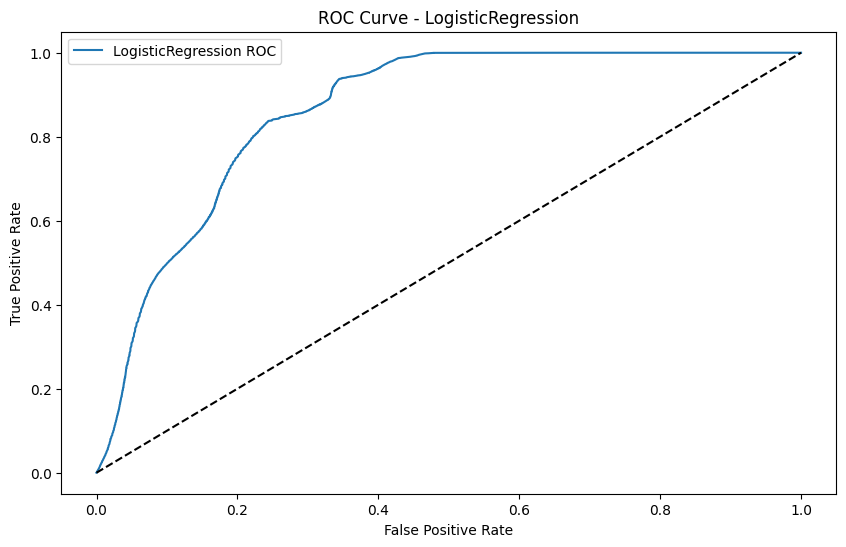

<Figure size 640x480 with 0 Axes>

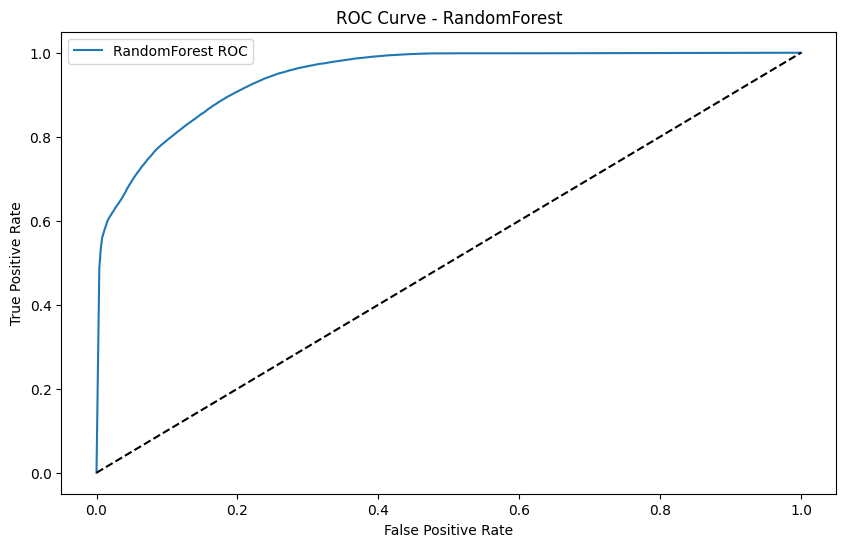

<Figure size 640x480 with 0 Axes>

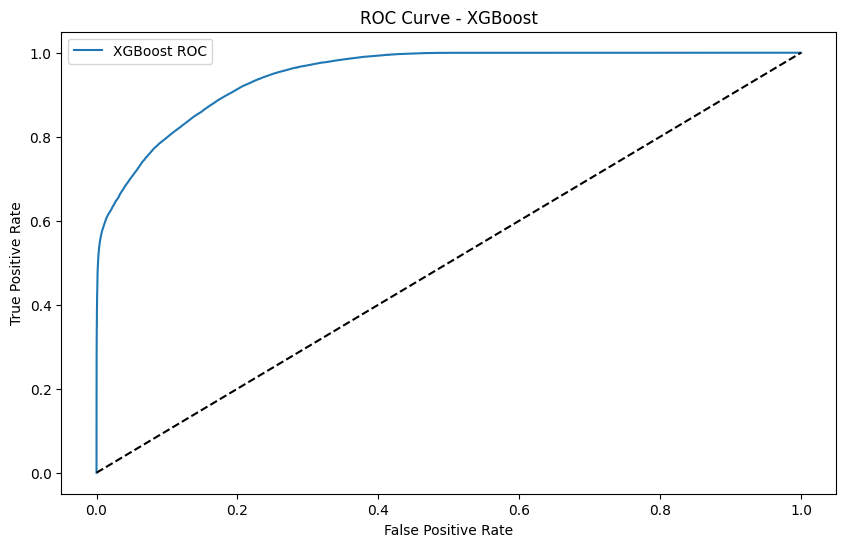

<Figure size 640x480 with 0 Axes>

In [9]:
#Saving ROC Curve Plots
figures_path =Path("../reports/figures")
figures_path.mkdir(parents=True, exist_ok = True)

def plot_roc(y_true, y_probs, name):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure(figsize=(10,6))
    plt.plot(fpr, tpr, label=f"{name} ROC")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()
    plt.savefig(figures_path/f"roc_{name.lower().replace(" ","_")}.png")
    
plot_roc(y_test, log_probs, "LogisticRegression")
plot_roc(y_test, rf_probs, "RandomForest")
plot_roc(y_test, xgb_probs, "XGBoost")

In [10]:
#Documenting Comparision
with open("../reports/model_comparison.md", "w") as f:
    f.write("Model Comparison\n\n")
    
    def write_metrics(name, preds, probs):
        f.write(f"## {name}\n\n")
        f1 = f1_score(y_test, preds)
        roc = roc_auc_score(y_test, probs)
        f.write(f"* ROC AUC: {roc:.4f}\n")
        f.write(f"* F1-Score (Fraud): {f1:.4f}\n")
        f.write("* Pros: \n* Cons: \n\n")
        
    write_metrics("Logistic Regression", log_preds, log_probs)
    write_metrics("Random Forest", rf_preds, rf_probs)
    write_metrics("XGBoost", xgb_preds, xgb_probs)
    
    f.write("**Final Choice**: XGBoost — best tradeoff between performance and scalability.\n")


In [16]:
#Saving Final model
# During training
feature_columns = X_train.columns.tolist()
joblib.dump(feature_columns, "../models/feature_columns.pkl")
final_model_path = Path("../models")
final_model_path.mkdir(parents = True, exist_ok = True)
joblib.dump(xgb_model, final_model_path / "final_model.pkl")
print("Model Saved")

Model Saved



--- Dummy Most Frequent ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     64953
           1       0.50      1.00      0.67     64952

    accuracy                           0.50    129905
   macro avg       0.25      0.50      0.33    129905
weighted avg       0.25      0.50      0.33    129905



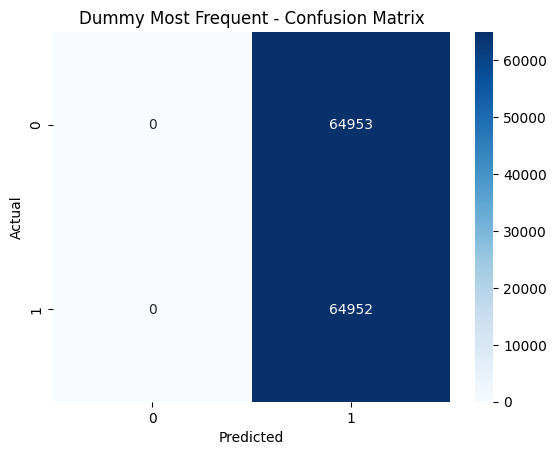


--- Dummy Stratified ---
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     64953
           1       0.50      0.50      0.50     64952

    accuracy                           0.50    129905
   macro avg       0.50      0.50      0.50    129905
weighted avg       0.50      0.50      0.50    129905



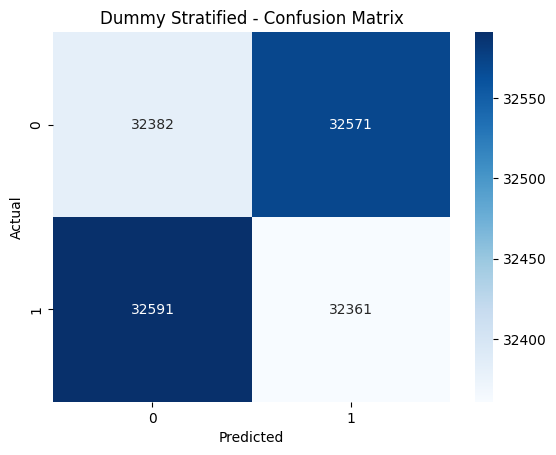


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.88      0.67      0.76     64953
           1       0.73      0.91      0.81     64952

    accuracy                           0.79    129905
   macro avg       0.81      0.79      0.79    129905
weighted avg       0.81      0.79      0.79    129905

ROC AUC: 0.8616951510232682


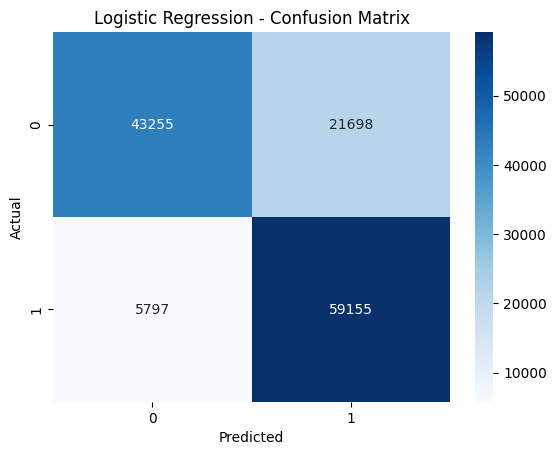

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Dummy Classifier - Most Frequent
dummy_most = DummyClassifier(strategy="most_frequent")
dummy_most.fit(X_train, y_train)
y_pred_dummy = dummy_most.predict(X_test)

#Dummy Classifier - Stratified
dummy_strat = DummyClassifier(strategy="stratified", random_state=42)
dummy_strat.fit(X_train, y_train)
y_pred_strat = dummy_strat.predict(X_test)

#Logistic Regression
logreg = LogisticRegression(class_weight="balanced", max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
y_proba_log = logreg.predict_proba(X_test)[:, 1]

def evaluate_model(name, y_true, y_pred, y_proba=None):
    print(f"\n--- {name} ---")
    print(classification_report(y_true, y_pred, zero_division=0))
    if y_proba is not None:
        print("ROC AUC:", roc_auc_score(y_true, y_proba))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Make sure the output folder exists
    output_dir = "reports/figures"
    os.makedirs(output_dir, exist_ok=True)

    # Save the plot
    filename = f"{name.lower().replace(' ', '_')}_cm.png"
    plt.savefig(os.path.join(output_dir, filename))
    plt.show()

# 5. Run Evaluations
evaluate_model("Dummy Most Frequent", y_test, y_pred_dummy)
evaluate_model("Dummy Stratified", y_test, y_pred_strat)
evaluate_model("Logistic Regression", y_test, y_pred_log, y_proba_log)


In [13]:
#Cross-Validation and Tuning
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# Define model
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'scale_pos_weight': [5, 10, 15]  # adjust for imbalance
}

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search
search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=skf,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Fit the model
search.fit(X_train, y_train)

# Best model
best_xgb = search.best_estimator_

# Evaluate on test
y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Metrics
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

#It is same(nearly) as before 


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\srmpc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:45:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC AUC: 0.9478546202177092
F1 Score: 0.8201906330156117
Precision: 0.6966850650398632
Recall: 0.9969208030545633
Confusion Matrix:
 [[36762 28191]
 [  200 64752]]


In [21]:
test.columns

Index(['age', 'policy_sales_channel', 'gender', 'previously_insured',
       'vehicle_age', 'vehicle_damage'],
      dtype='object')

 98%|===================| 38287/38972 [00:35<00:00]        

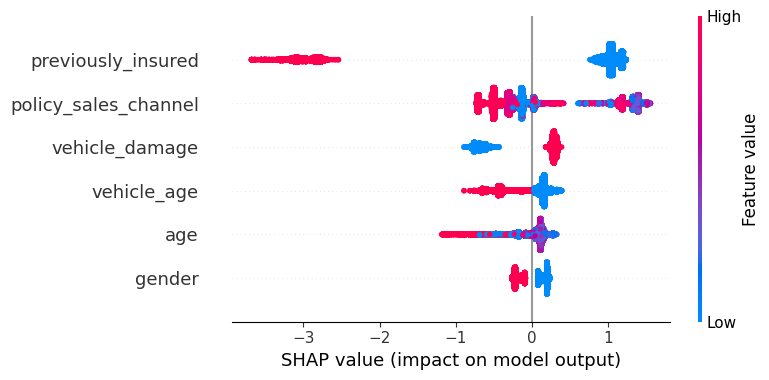

<Figure size 640x480 with 0 Axes>

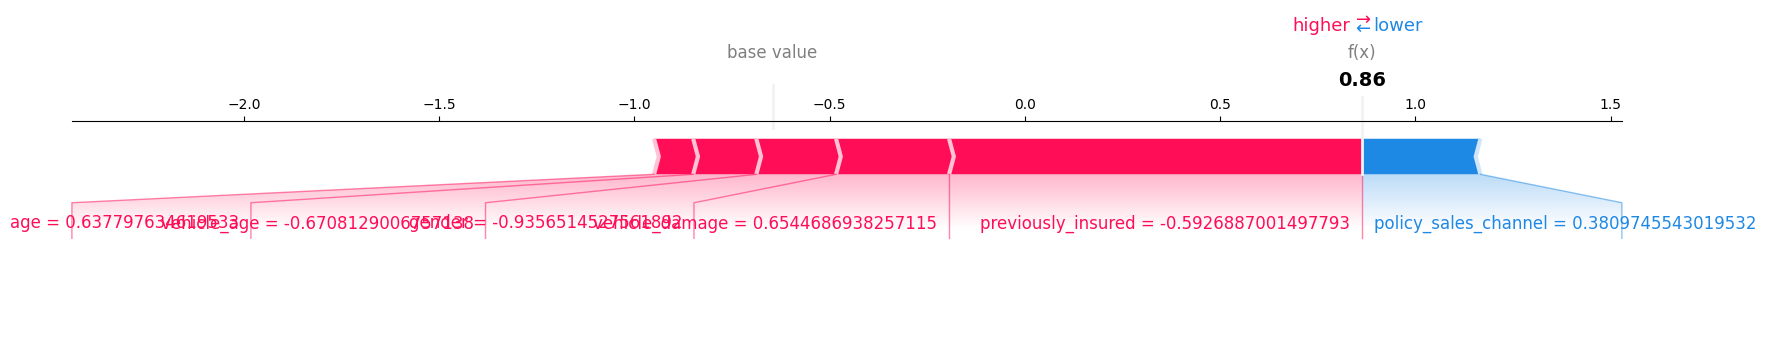

<Figure size 640x480 with 0 Axes>

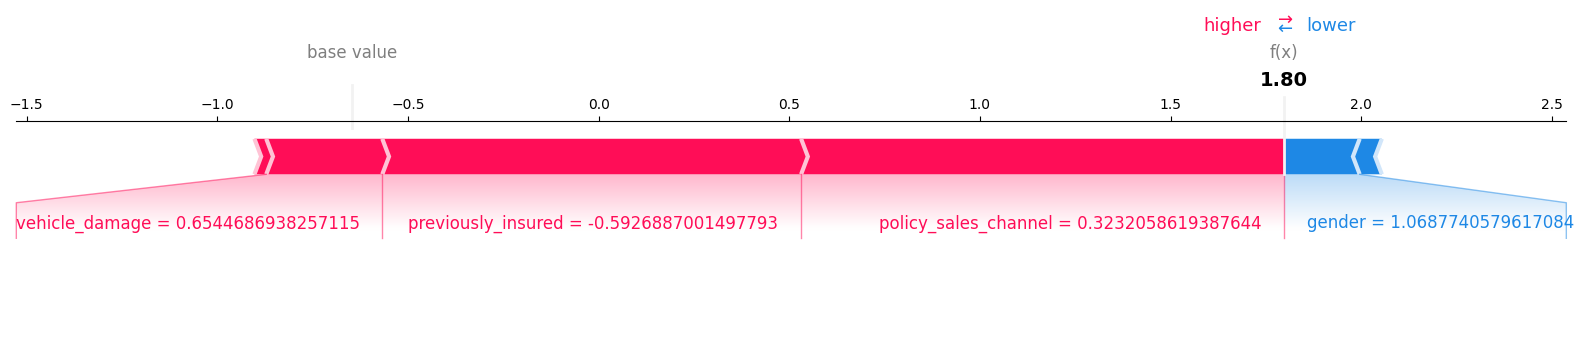

<Figure size 640x480 with 0 Axes>

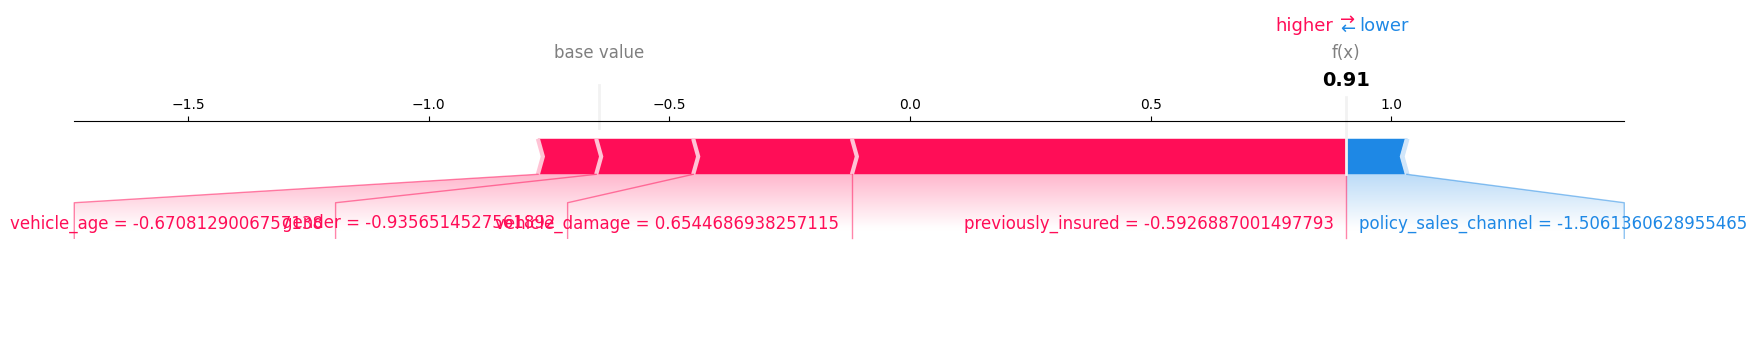

✅ SHAP visualizations saved in '../figures/'


In [ ]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

#Here I've reduced my data to 0.3 percentage
train = pd.read_csv("../data/labeled/labeled_data.csv")
train = train.sample(frac=0.3, random_state=42).reset_index(drop=True)  # ⚡ Use 30% data for faster training
feature_columns = ['age', 'policy_sales_channel', 'gender', 'previously_insured', 'vehicle_age', 'vehicle_damage']
X = train[feature_columns]
y = train['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_columns)

#Training Model (Fast Mode)
model = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    tree_method='hist',
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)
model.fit(X_train_scaled, y_train)

#Save Artifacts
joblib.dump(model, '../models/final_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')
joblib.dump(feature_columns, '../models/feature_columns.pkl')

#SHAP Explainer (TreeExplainer for XGBoost)
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled)

#SHAP Summary Bar
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", show=False)
plt.savefig("../figures/shap_summary_bar.png", bbox_inches="tight")

#SHAP Beeswarm
shap.summary_plot(shap_values, X_test_scaled, show=False)
plt.savefig("../figures/shap_beeswarm.png", bbox_inches="tight")

#SHAP Force Plots for Top 3 Predicted Frauds
y_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)
fraud_indices = X_test_scaled.index[y_pred == 1][:3]

for i, idx in enumerate(fraud_indices):
    plt.figure()
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx].values,
        X_test_scaled.loc[idx],
        matplotlib=True
    )
    plt.savefig(f"../figures/shap_force_plot_{i+1}.png", bbox_inches="tight")
    plt.close()

print("SHAP visualizations saved in '../figures/'")


In [3]:
import pandas as pd
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import os

# Make sure models/ directory exists
os.makedirs("models", exist_ok=True)

# ---------------- Load & Prepare Data ---------------- #
df = pd.read_csv("../data/labeled/labeled_data.csv")  # Adjust path
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------- Build Preprocessor ---------------- #
numeric_features = ['age', 'policy_sales_channel']
categorical_features = ['gender', 'previously_insured', 'vehicle_age', 'vehicle_damage']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# ---------------- Build Full Pipeline ---------------- #
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# ---------------- Train & Save ---------------- #
pipeline.fit(X_train, y_train)
os.makedirs("models", exist_ok=True)

joblib.dump(pipeline, "../models/xgb_pipeline.pkl")
print("Saved pipeline to models/xgb_pipeline.pkl")


c:\Users\srmpc\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:19:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saved pipeline to models/xgb_pipeline.pkl
